In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


#disable warning messages inside the notebook
pd.options.mode.chained_assignment = None

## I. Data Import

In [2]:
#load Kaggle dataset
df = pd.read_csv('fake-news/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## II. Data Exploration

In [3]:
#display general info to the imported data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [4]:
#briefly check on the label distribution
df_reliable = df.loc[df['label'] == 0]
df_unreliable = df.loc[df['label'] == 1]

total = len(df_reliable) + len(df_unreliable)

print('Control: sum: {} , reliable: {}, unreliable: {}'.format(total, len(df_reliable), len(df_unreliable)))
print('Ratio reliable/unreliable messages: {}:{}'. \
          format(round(len(df_reliable) / total, 2), round(len(df_unreliable) / total, 2)))

Control: sum: 20800 , reliable: 10387, unreliable: 10413
Ratio reliable/unreliable messages: 0.5:0.5


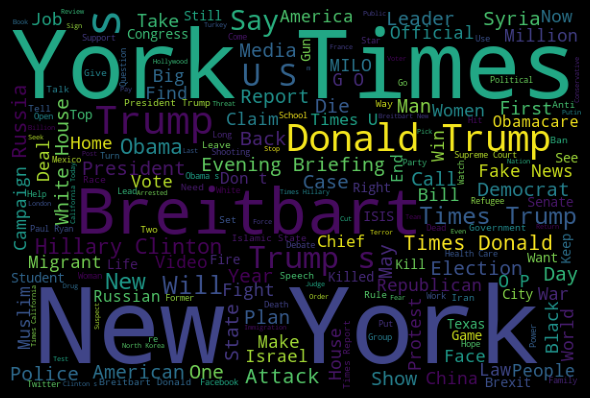

In [5]:
#create a wordcloud for the label reliable
reliable_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df_reliable['title']))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(reliable_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

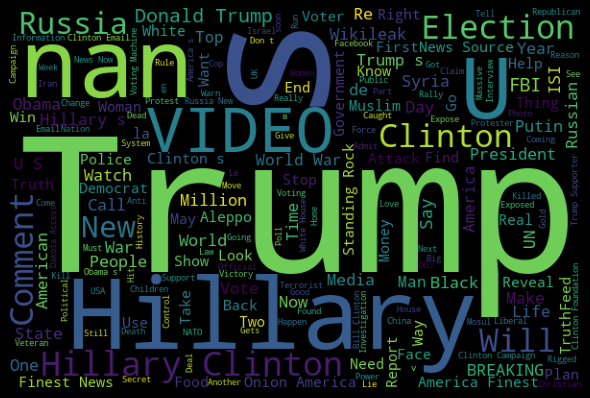

In [6]:
#create a wordcloud for the label unreliable
unreliable_wordcloud = WordCloud(width=600, height=400).generate(' '.join(str(item) for item in df_unreliable['title']))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(unreliable_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [7]:
#anlaysis of the text length for text labeled as reliable
df_reliable['title_length'] = df['title'].str.len()
df_reliable.head()

,id,title,author,text,label,title_length
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55.0
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,124.0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,87.0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,104.0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,93.0


In [8]:
df_reliable['title_length'].describe()

count    10387.000000
mean        79.594974
std         15.568225
min         22.000000
25%         70.000000
50%         81.000000
75%         89.000000
max        175.000000
Name: title_length, dtype: float64

In [9]:
df_reliable['title_length'].sort_values()

19430     22.0
13560     24.0
15081     25.0
7877      26.0
9036      26.0
         ...  
13638    141.0
2217     141.0
5200     141.0
18446    153.0
16901    175.0
Name: title_length, Length: 10387, dtype: float64

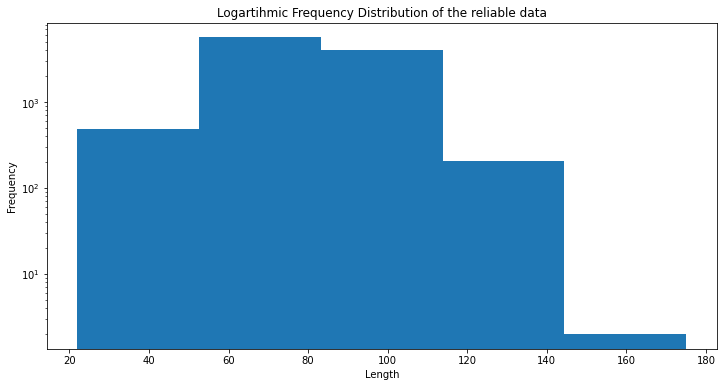

In [15]:
#plot a histogram of the text length distribution for reliable text
plt.figure(figsize=(12,6))
df_reliable['title_length'].plot(bins=5, kind='hist')  
plt.title("Logartihmic Frequency Distribution of the reliable data")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.yscale("log")

In [17]:
#anlaysis of the text length for text labeled as unreliable
df_unreliable['title_length'] = df['title'].str.len()
df_unreliable.head()

,id,title,author,text,label,title_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63.0
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93.0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,110.0


In [18]:
df_unreliable['title_length'].describe()

count    9855.000000
mean       68.758904
std        28.040182
min         3.000000
25%        50.000000
50%        67.000000
75%        84.000000
max       456.000000
Name: title_length, dtype: float64

In [19]:
df_unreliable['title_length'].sort_values()

15728    3.0
2561     4.0
17081    4.0
20523    5.0
86       6.0
        ... 
20568    NaN
20627    NaN
20636    NaN
20771    NaN
20772    NaN
Name: title_length, Length: 10413, dtype: float64

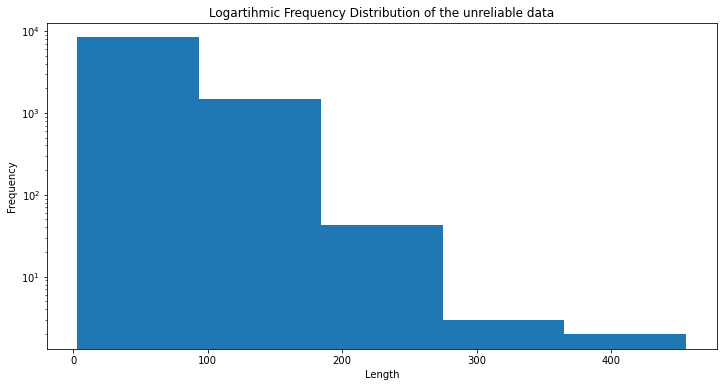

In [20]:
#plot a histogram of the text length distribution for unreliable text
plt.figure(figsize=(12,6))
df_unreliable['title_length'].plot(bins=5, kind='hist')  
plt.title("Logartihmic Frequency Distribution of the unreliable data")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.yscale("log")

## III. Data Pre-Processing

In [21]:
#remove records which include np.nan in the text column
check_nan = df['title'].isnull().sum()
print(check_nan)

df_cleaned = df[df['title'].notnull()]
df_cleaned.info()

558
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20242 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20242 non-null  int64 
 1   title   20242 non-null  object
 2   author  18285 non-null  object
 3   text    20203 non-null  object
 4   label   20242 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 948.8+ KB


In [23]:
#I will set the cut off for the maximum text length to 60.000 characters
#and remove the outliers from the original dataset
df_cleaned['title_length'] = df_cleaned['title'].str.len()
df_cleaned = df_cleaned[df_cleaned['title_length'] < 300]
df_cleaned.describe()

,id,label,title_length
count,20240.000000,20240.000000,20240.000000
mean,10398.630237,0.486808,74.284585
std,6000.982073,0.499838,22.895743
min,0.000000,0.000000,3.000000
25%,5207.750000,0.000000,60.000000
50%,10403.500000,0.000000,75.000000
75%,15584.250000,1.000000,88.000000
max,20799.000000,1.000000,289.000000


In [24]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20240 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            20240 non-null  int64 
 1   title         20240 non-null  object
 2   author        18283 non-null  object
 3   text          20201 non-null  object
 4   label         20240 non-null  int64 
 5   title_length  20240 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


That action removed 2 records in total.

In [25]:
#printing the punctuation values which I am going to remove from the corpus
punc = string.punctuation 
print('Characters to be removed off the dataset: {}'.format(punc)) 

Characters to be removed off the dataset: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
%%time

#remove punctuations and lower all characters
def remove_punctuation_lower(s): 
    """ Helper function to remove punctuation from a string s
        and to lower the characters: any string """ 
    
    try: 
        nopunc = ''.join(char for char in s if char not in string.punctuation)
        nopunc = nopunc.lower()
    except e: 
        print(e)
    
    return nopunc

#apply remove_punctuation_lower() to the dataframe
df_cleaned['title_nopunc'] = df_cleaned['title'].apply(remove_punctuation_lower)
df_cleaned.head()

CPU times: user 176 ms, sys: 5.68 ms, total: 182 ms
Wall time: 184 ms


,id,title,author,text,label,title_length,title_nopunc
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,house dem aide we didn’t even see comey’s lett...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,flynn hillary clinton big woman on campus bre...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,why the truth might get you fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,15 civilians killed in single us airstrike hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,iranian woman jailed for fictional unpublished...


In [27]:
%%time

#remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(s): 
    """ Helper function to remove stopwords from a string s: any string """ 
    
    try: 
        tokens = word_tokenize(s)
        #no_stopwords = [word for word in tokens if not word in stopwords.words('english')]
        #no_stopwords = " ".join(no_stopwords)
        no_stopwords = ' '.join(word for word in tokens if word not in stop_words)
    except e:
        print(e)
    
    return no_stopwords

#apply remove_stopwords() to the dataframe
df_cleaned['title_no_stopwords'] = df_cleaned['title_nopunc'].apply(remove_stopwords)
df_cleaned['title_no_stopwords_length'] = df_cleaned['title_no_stopwords'].str.len()
df_cleaned.describe()

[nltk_data] Downloading package stopwords to /Users/pika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 1.67 s, sys: 13.7 ms, total: 1.68 s
Wall time: 1.77 s


,id,label,title_length,title_no_stopwords_length
count,20240.000000,20240.000000,20240.000000,20240.000000
mean,10398.630237,0.486808,74.284585,60.631472
std,6000.982073,0.499838,22.895743,19.670815
min,0.000000,0.000000,3.000000,0.000000
25%,5207.750000,0.000000,60.000000,48.000000
50%,10403.500000,0.000000,75.000000,61.000000
75%,15584.250000,1.000000,88.000000,72.000000
max,20799.000000,1.000000,289.000000,227.000000


In [28]:
%%time

#lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatization(s):
    """ Helper function to convert words into their dictionary form from a string s: any string """ 
    
    wnl = WordNetLemmatizer()
    
    try:
        tokens = word_tokenize(s)
        lemmas = ' '.join([wnl.lemmatize(word) for word in tokens])
    except e:
        print(e)                  
                       
    return lemmas

#apply lemmatization() to the dataframe
df_cleaned['title_lemmas'] = df_cleaned['title_no_stopwords'].apply(lemmatization)

[nltk_data] Downloading package wordnet to /Users/pika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/pika/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CPU times: user 3.58 s, sys: 55 ms, total: 3.64 s
Wall time: 3.68 s


In [29]:
#quick check on how many words and punctuations have been removed
df_cleaned['count_before'] = df_cleaned['title_nopunc'].apply(lambda x: len(str(x).split()))
df_cleaned['count_after'] = df_cleaned['title_lemmas'].apply(lambda x: len(str(x).split()))
df_cleaned.head()

,id,title,author,text,label,title_length,title_nopunc,title_no_stopwords,title_no_stopwords_length,title_lemmas,count_before,count_after
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,house dem aide we didn’t even see comey’s lett...,house dem aide ’ even see comey ’ letter jason...,63,house dem aide ’ even see comey ’ letter jason...,14,12
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,flynn hillary clinton big woman on campus bre...,flynn hillary clinton big woman campus breitbart,48,flynn hillary clinton big woman campus breitbart,8,7
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,why the truth might get you fired,truth might get fired,21,truth might get fired,7,4
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,15 civilians killed in single us airstrike hav...,15 civilians killed single us airstrike identi...,50,15 civilian killed single u airstrike identified,10,7
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished sto...,76,iranian woman jailed fictional unpublished sto...,14,10


In [30]:
print('Word count before: {}, after: {}, diff: {} or {:.0f}%'.format( \
                                                    df_cleaned['count_before'].sum(), df_cleaned['count_after'].sum(), \
                                                    df_cleaned['count_after'].sum() - df_cleaned['count_before'].sum(), \
                                                    (df_cleaned['count_after'].sum()/df_cleaned['count_before'].sum()-1)*100))

Word count before: 241249, after: 190567, diff: -50682 or -21%


## IV. Vectorization

In [31]:
%%time

#transform the list of tokens into a vector
vectorizer = CountVectorizer()
v_fit = vectorizer.fit(df_cleaned['title_lemmas'])
v_transform = vectorizer.transform(df_cleaned['title_lemmas'])

print("Total number of words : ",len(vectorizer.vocabulary_))
print('Vector shape after transformation: {}'.format(v_transform.shape))

Total number of words :  21652
Vector shape after transformation: (20240, 21652)
CPU times: user 333 ms, sys: 8.27 ms, total: 342 ms
Wall time: 343 ms


## V. Modelling with TF-IDF

In [32]:
#calculate the TF-IDF
tfidf_transformer = TfidfTransformer().fit(v_transform)
text_tfidf = tfidf_transformer.transform(v_transform)

In [33]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16192, 21652)
train dataset label size (16192,)
--------------------
test dataset features size (4048, 21652)
test dataset lable size (4048,)


In [34]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 5.42 ms, sys: 1.57 ms, total: 6.99 ms
Wall time: 5.54 ms


## Evaluation

In [35]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2082
           1       0.96      0.78      0.86      1966

    accuracy                           0.88      4048
   macro avg       0.89      0.88      0.88      4048
weighted avg       0.89      0.88      0.88      4048



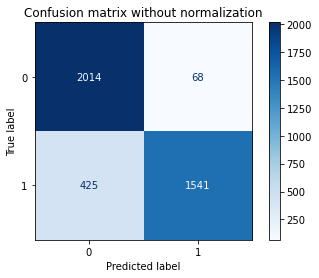

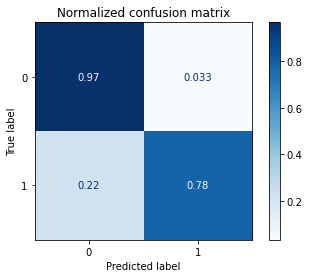

In [36]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of TF-IDF Modelling & Evaluation with different ML algorithms

In [37]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 9.89 s, sys: 222 ms, total: 10.1 s
Wall time: 10.2 s


In [38]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2082
           1       0.90      0.97      0.94      1966

    accuracy                           0.93      4048
   macro avg       0.94      0.94      0.93      4048
weighted avg       0.94      0.93      0.93      4048



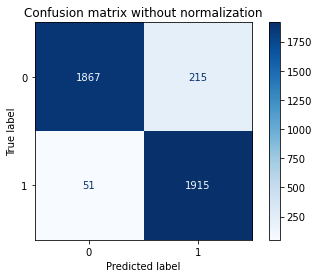

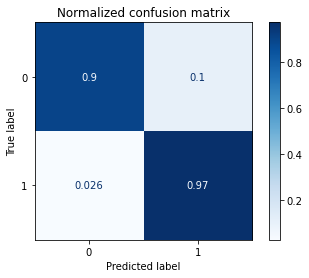

In [39]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [40]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 2.18 s, sys: 17.8 ms, total: 2.19 s
Wall time: 2.22 s


In [41]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2082
           1       0.91      0.92      0.91      1966

    accuracy                           0.92      4048
   macro avg       0.92      0.92      0.92      4048
weighted avg       0.92      0.92      0.92      4048



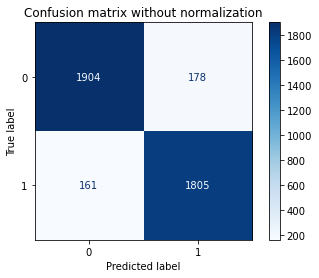

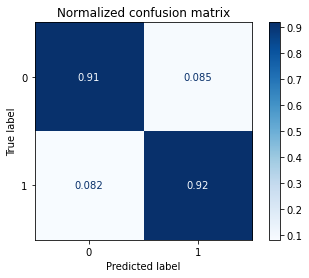

In [42]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## VII. Modelling with TF

In [43]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(v_transform, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16192, 21652)
train dataset label size (16192,)
--------------------
test dataset features size (4048, 21652)
test dataset lable size (4048,)


In [44]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 6.18 ms, sys: 1.83 ms, total: 8.01 ms
Wall time: 6.21 ms


In [45]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2082
           1       0.95      0.85      0.90      1966

    accuracy                           0.91      4048
   macro avg       0.91      0.90      0.90      4048
weighted avg       0.91      0.91      0.91      4048



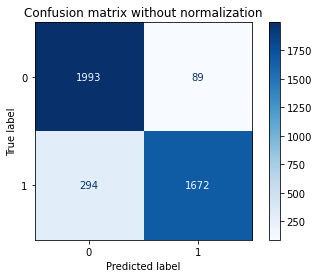

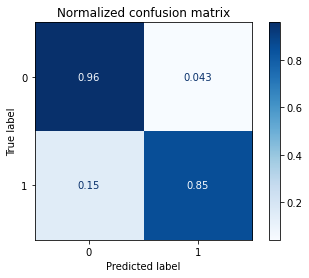

In [46]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of TF Modelling & Evaluation with different ML algorithms

In [47]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 7.1 s, sys: 123 ms, total: 7.22 s
Wall time: 7.28 s


In [48]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2082
           1       0.92      0.95      0.93      1966

    accuracy                           0.93      4048
   macro avg       0.93      0.93      0.93      4048
weighted avg       0.93      0.93      0.93      4048



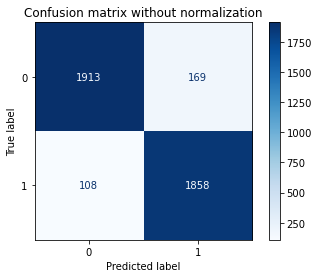

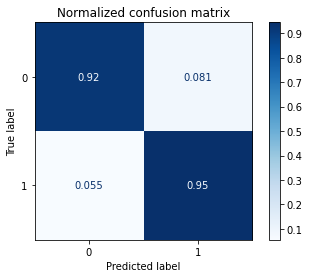

In [49]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [50]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 1.62 s, sys: 8.03 ms, total: 1.63 s
Wall time: 1.64 s


In [51]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2082
           1       0.92      0.93      0.92      1966

    accuracy                           0.93      4048
   macro avg       0.93      0.93      0.93      4048
weighted avg       0.93      0.93      0.93      4048



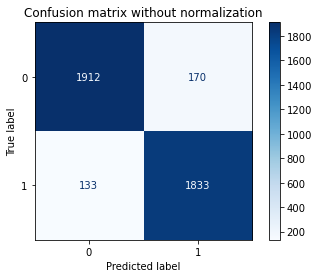

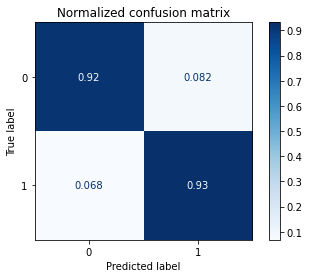

In [52]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## VIII. Bigram Vectorization

In [65]:
%%time

#transform the list of tokens into a vector
vectorizer = CountVectorizer(ngram_range=(2,2))
v_fit = vectorizer.fit(df_cleaned['title_lemmas'])
v_transform = vectorizer.transform(df_cleaned['title_lemmas'])

print("Total number of words : ",len(vectorizer.vocabulary_))
print('Vector shape after transformation: {}'.format(v_transform.shape))

Total number of words :  106593
Vector shape after transformation: (20240, 106593)
CPU times: user 678 ms, sys: 10.2 ms, total: 689 ms
Wall time: 691 ms


## IX. Modelling with Bigram

In [66]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(v_transform, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16192, 106593)
train dataset label size (16192,)
--------------------
test dataset features size (4048, 106593)
test dataset lable size (4048,)


In [67]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 8.15 ms, sys: 4 ms, total: 12.1 ms
Wall time: 10.7 ms


In [68]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2082
           1       0.86      0.90      0.88      1966

    accuracy                           0.88      4048
   macro avg       0.88      0.88      0.88      4048
weighted avg       0.88      0.88      0.88      4048



## Evaluation

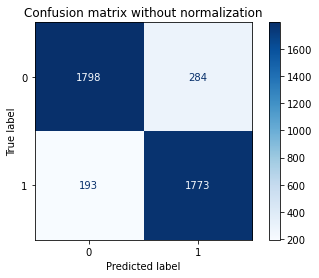

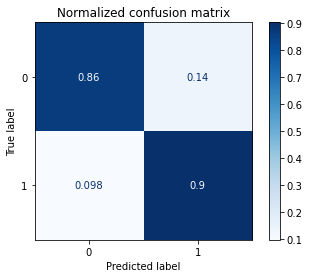

In [69]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of Bigram Modelling & Evaluation with different ML algorithms

In [70]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 34 s, sys: 324 ms, total: 34.3 s
Wall time: 34.7 s


In [71]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2082
           1       0.79      0.98      0.88      1966

    accuracy                           0.86      4048
   macro avg       0.88      0.87      0.86      4048
weighted avg       0.89      0.86      0.86      4048



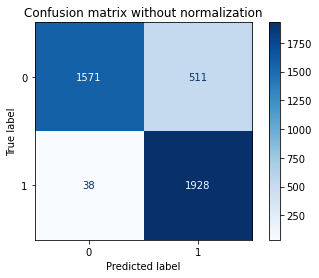

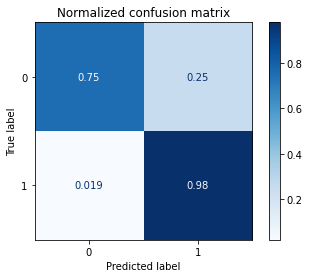

In [72]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [73]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 12.8 s, sys: 49.6 ms, total: 12.8 s
Wall time: 12.9 s


In [74]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      2082
           1       0.80      0.96      0.87      1966

    accuracy                           0.87      4048
   macro avg       0.88      0.87      0.87      4048
weighted avg       0.88      0.87      0.87      4048



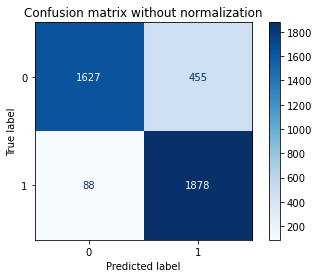

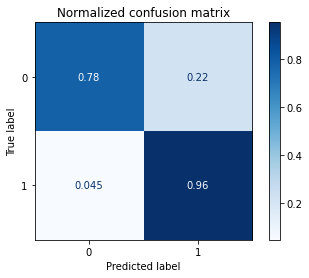

In [75]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)